In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import random 
from scipy.stats import multivariate_normal as mvn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:


data = scipy.io.loadmat('./data/data.mat')
data = data['data'].T
lbl = scipy.io.loadmat('./data/label.mat')
lbl = lbl['trueLabel']

print(data.shape)
print(lbl.shape)
display(lbl)

(1990, 784)
(1, 1990)


array([[2, 2, 2, ..., 6, 6, 6]], dtype=uint8)

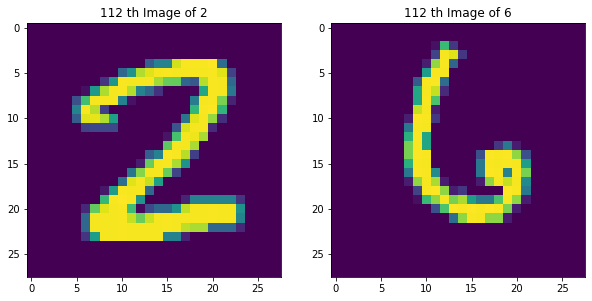

In [3]:
# Q1.a plotting random 2 and 6

fig, axes = plt.subplots(1,2,figsize=(10,5))
rand=random.randint(1,1032)
axes[0].imshow(data[np.argwhere(lbl==2)[:,1][rand],:].reshape((28,28)).T)
axes[0].set_title("{} th Image of 2".format(rand))
axes[1].imshow(data[np.argwhere(lbl==6)[:,1][rand],:].reshape((28,28)).T)
axes[1].set_title("{} th Image of 6".format(rand));
plt.show()

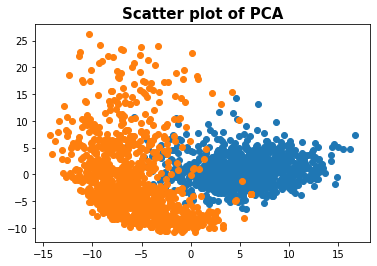

starting iteration, 0
starting iteration, 1
starting iteration, 2
starting iteration, 3
starting iteration, 4
starting iteration, 5
starting iteration, 6
starting iteration, 7
starting iteration, 8
starting iteration, 9
starting iteration, 10
starting iteration, 11
starting iteration, 12
starting iteration, 13
starting iteration, 14
starting iteration, 15
starting iteration, 16
starting iteration, 17
starting iteration, 18
starting iteration, 19
starting iteration, 20
starting iteration, 21
starting iteration, 22
starting iteration, 23
starting iteration, 24
training coverged
[-64480.328679318394, -30228.982163320004, -29863.90706429426, -29480.983264177536, -29219.693493032573, -29082.440045407835, -28991.802078862318, -28945.498594707802, -28930.44505240937, -28926.47377719405, -28925.344722226786, -28924.921658718646, -28924.72116297928, -28924.615605336785, -28924.557718473377, -28924.52536697856, -28924.507080187876, -28924.496660874534, -28924.490688797057, -28924.48725020138, -2

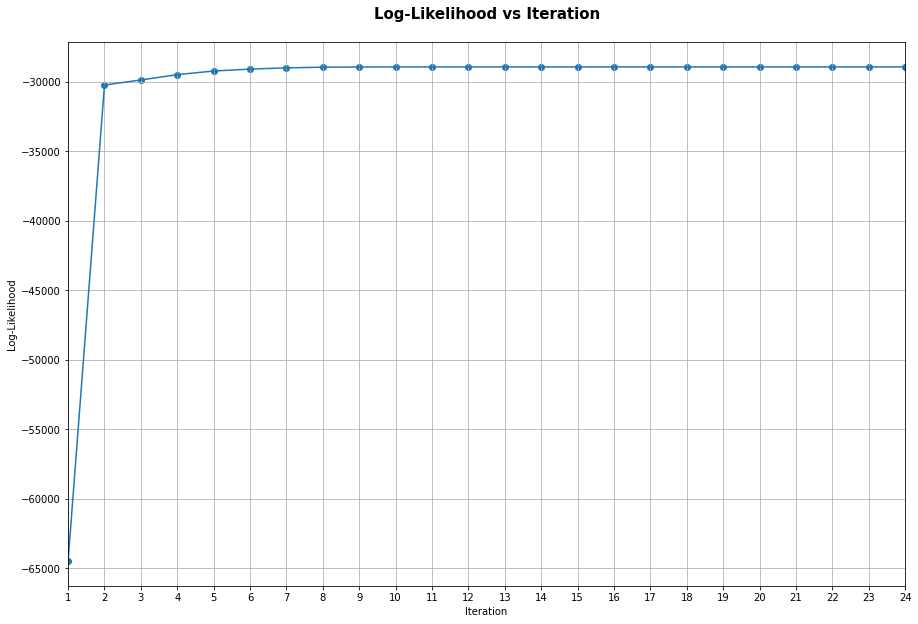

In [4]:
# Q1c: Implementation of EM algorithm with initialization for mean and initialization for covariance
data = scipy.io.loadmat('./data/data.mat')
data = data['data'].T
label = scipy.io.loadmat('./data/label.mat')
label = label['trueLabel']

scaler = preprocessing.StandardScaler().fit(data)
ndata = scaler.transform(data)


# # ndata = preprocessing.scale(data)
m, n = data.shape
# # (900,784)
# C = np.matmul(ndata.T, ndata)/m

# # pca the data
# d = 5  # reduced dimension
# V,ev,_ = np.linalg.svd(C)
# V = V[:, :d]

pca = PCA(n_components=5)
pdata= pca.fit_transform(ndata)


# project the data to the top 2 principal directions
# pdata = np.dot(ndata,V)
# display(pdata)

plt.scatter(pdata[np.where(label == 2),0],pdata[np.where(label == 2),1])
plt.scatter(pdata[np.where(label == 6),0],pdata[np.where(label == 6),1])
plt.title("Scatter plot of PCA", fontsize=15, weight='bold')
plt.show()

# EM-GMM
K = 2


# initialize prior
# np.random.seed(seed)
pi = np.random.random(K)
pi = pi/np.sum(pi)

# initial mean and covariance
# np.random.seed(seed)
mu = np.random.randn(K,5)
mu_old = mu.copy()

I=np.identity(5)
sigma = []
for ii in range(K):
    # to ensure the covariance psd
    # np.random.seed(seed)
    dummy = np.random.randn(5, 5)
    sigma.append(dummy@dummy.T+I)
    
# initialize the posterior
tau = np.full((m, K), fill_value=0.)

# # parameter for countour plot
# xrange = np.arange(-5, -5, 0.1)
# yrange = np.arange(-5, -5, 0.1)

# ####
maxIter= 100
tol = 1e-3

plt.ion()
logLH=[]
for ii in range(100):
    print("starting iteration,",ii)
    # E-step    
    collection=[]
    for kk in range(K):
        tau[:, kk] = pi[kk] * mvn.pdf(pdata, mu[kk], sigma[kk])
    sum_tau = np.sum(tau, axis=1)
    sum_tau.shape = (m,1)    
    l = np.sum(np.log(np.sum(tau, axis=1)))
    logLH.append(l)
    
    tau = np.divide(tau, np.tile(sum_tau, (1, K)))
    
    
    # M-step
    for kk in range(K):
        # update prior
        pi[kk] = np.sum(tau[:, kk])/m
        
        # update component mean
        mu[kk] = pdata.T @ tau[:,kk] / np.sum(tau[:,kk], axis = 0)
        
        # update cov matrix
        dummy = pdata - np.tile(mu[kk], (m,1)) # X-mu
        sigma[kk] = dummy.T @ np.diag(tau[:,kk]) @ dummy / np.sum(tau[:,kk], axis = 0)
        

    
    if np.linalg.norm(mu-mu_old) < tol:
        print('training coverged')
        break
    mu_old = mu.copy()
    if ii==99:
        print('max iteration reached')
        break

print(logLH)
        
plt.figure(figsize=(15,10))
plt.title("Log-Likelihood vs Iteration\n", fontsize=15, weight='bold')
plt.plot(np.arange(1,ii+2),logLH)
plt.scatter(np.arange(1,ii+2),logLH)
plt.xlabel('Iteration')
plt.ylabel("Log-Likelihood")
plt.xticks(np.arange(1,ii+2))
plt.xlim(1,ii)
# plt.gca().invert_yaxis()
plt.grid('both');


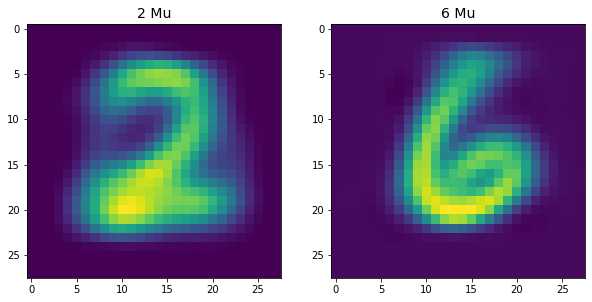

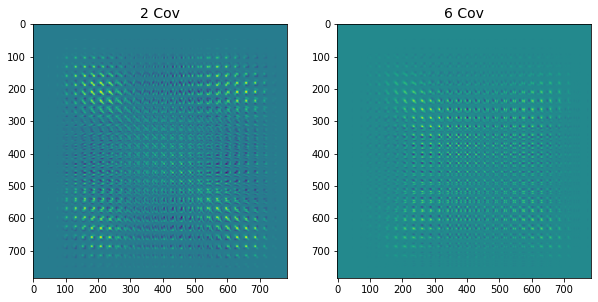

In [5]:
# Q1d: Report, the fitted GMM model when EM has terminated 

# D= np.diag(ev[:5])
res_mean_2= pca.inverse_transform(mu[0])
res_mean_2= scaler.inverse_transform(res_mean_2)

res_mean_6= pca.inverse_transform(mu[1])
res_mean_6= scaler.inverse_transform(res_mean_6)

fig, axes = plt.subplots(1,2,figsize=(10,5))
plt.title("Inverse transformed images of 2 and 6 for mu")
axes[0].imshow(res_mean_2.reshape(28,28).T)
axes[0].set_title("2 Mu", fontsize=14);
axes[1].imshow(res_mean_6.reshape(28,28).T)
axes[1].set_title("6 Mu", fontsize=14);
plt.show()

res_cov_2 = pca.inverse_transform(pca.inverse_transform(sigma[0]).T)
res_cov_6 = pca.inverse_transform(pca.inverse_transform(sigma[1]).T)
fig, axes = plt.subplots(1,2,figsize=(10,5))
plt.title("Inverse transformed images of 2 and 6 for covariance")
axes[0].imshow(res_cov_2)
axes[0].set_title("2 Cov", fontsize=14);
axes[1].imshow(res_cov_6)
axes[1].set_title("6 Cov", fontsize=14);
plt.show()

In [6]:
# Q1e Find out the mis-classification rate for digits “2” and “6”

classification=[]
for t in tau:
    result = 2 if t[0]>=t[1] else 6
    classification.append(result)
c = np.array([classification])

miscalc_2=0
miscalc_6=0
total_2=np.count_nonzero(lbl == 2)
total_6=np.count_nonzero(lbl == 6)

for orig,calc in zip(lbl.T[:,0],c.T[:,0]):
#     print(orig,calc)
    if orig!=calc:
        if orig==2:
            miscalc_2+=1
        if orig==6:
            miscalc_6+=1

print("miscal_2",miscalc_2)
print("miscal_6",miscalc_6)
print("total 2s:",total_2)
print("total 6s:",total_6)

miscalc_rate_2=miscalc_2/total_2
miscalc_rate_6=miscalc_6/total_6

print(miscalc_rate_2*100)
print(miscalc_rate_6*100)


kmeans = KMeans(2)

np.random.seed(1)
kmeans.fit(data)

predictions = kmeans.labels_
predictions[predictions==0]=2
predictions[predictions==1]=6

miscalc_2=0
miscalc_6=0
print("predictions",predictions)
for orig,pred in zip(lbl.T[:,0],predictions):
    if orig!=pred:
            if orig==2:
                miscalc_2+=1
            if orig==6:
                miscalc_6+=1

print("miscal_2",miscalc_2)
print("miscal_6",miscalc_6)
print("total 2s:",total_2)
print("total 6s:",total_6)

miscalc_rate_2=miscalc_2/total_2
miscalc_rate_6=miscalc_6/total_6

print(miscalc_rate_2*100)
print(miscalc_rate_6*100)

        

miscal_2 25
miscal_6 152
total 2s: 1032
total 6s: 958
2.422480620155039
15.866388308977037
predictions [2 2 2 ... 2 6 6]
miscal_2 55
miscal_6 68
total 2s: 1032
total 6s: 958
5.329457364341085
7.09812108559499
